# **Setting & Introduction**

## **1. Github 연동**

In [1]:
""" github 연동 """
!git clone https://github.com/ku-sungsukim/2025-LGElec-Day22.git ### colab 사용 시

Cloning into '2025-LGElec-Day22'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 58 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 19.54 MiB | 10.26 MiB/s, done.
Resolving deltas: 100% (10/10), done.


## **2. About Jupyter Notebook**

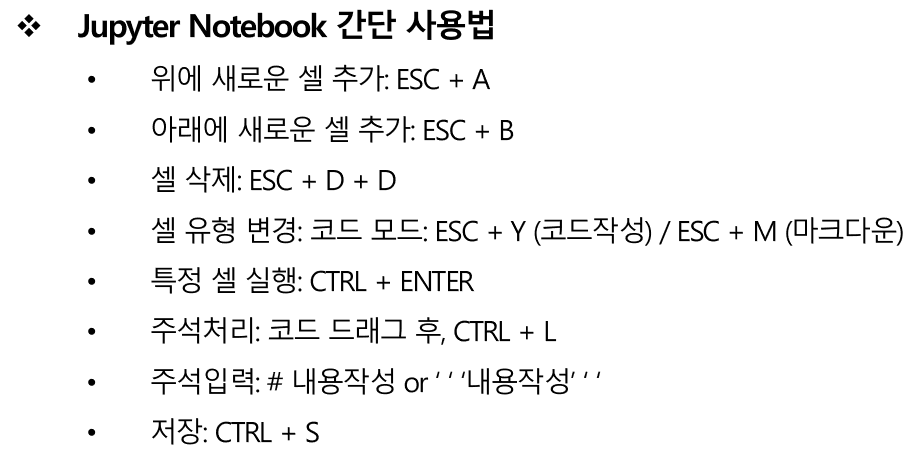

In [2]:
""" 설명 장표 불러오기 """
from IPython.display import Image
# Image('image/1-Introduction2.PNG') ### 로컬 사용 시
Image('/content/2025-LGElec-Day22/image/1-Introduction2.PNG') ### colab 사용 시

## **[Data Balancing & XAI 실습 목차]**
 - (1) Data Balancing (1) - UnderSampling

 - ***(2) Data Balancing (2) - Oversampling √***

 - (3) XAI

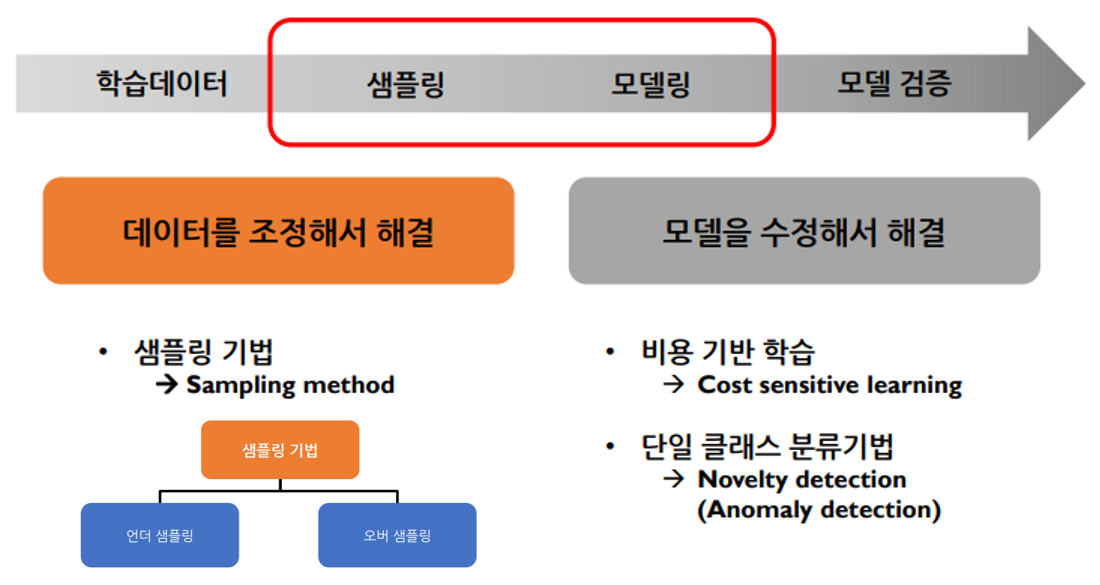

In [3]:
""" 설명 장표 불러오기 """
# Image('image/3-DataBalancing1.PNG') ### 로컬 사용 시
Image('/content/2025-LGElec-Day22/image/3-DataBalancing1.PNG') ### colab 사용 시

## **[Data Balancing - OverSampling - GAN 목차]**

  - GAN 모델 학습

  - 소수 Class OverSampling

  - 모델 성능 비교

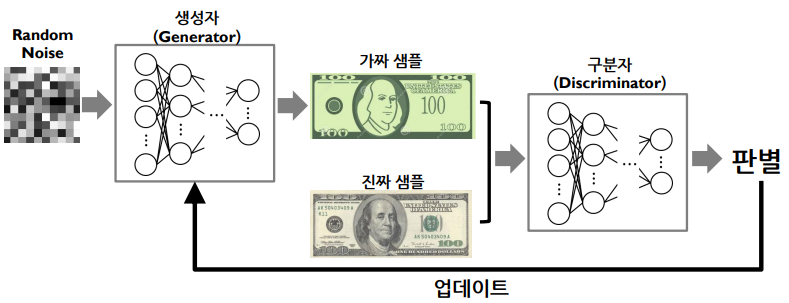

In [4]:
""" 설명 장표 불러오기 """
# Image('image/7-GAN1.PNG') ### 로컬 사용 시
Image('/content/2025-LGElec-Day22/image/7-GAN1.PNG') ### colab 사용 시

## **0. 모델링 환경 설정**

#### **0-1. 필요 패키지 불러오기**

In [5]:
""" 실습에 필요한 패키지 불러오기 """


""" 기본 연산과 관련된 패키지 """
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm


""" 모델링 및 성능 산출과 관련된 패키지"""
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


""" GAN 모델링 """
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


""" 데이터 시각화 패키지 """
import seaborn as sns
import matplotlib.pyplot as plt


""" 경고 숨기기 """
import warnings
warnings.filterwarnings('ignore')

#### **0-2. 필요 함수 사전 정의**

In [6]:
""" (1) Confusion Matrix를 시각화하는 함수 """

def plot_confusion_matrix(confusion_matrix, classes):

    ### Confusion Matrix 시각화
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    ### X축 및 Y축 눈금에 Class 표시
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    ### Confusion Matrix 숫자 기입
    thresh = confusion_matrix.max() / 2. ### 폰트 색상 지정을 위한 Threshold
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'), ### 숫자 작성
                 horizontalalignment="center", ### 숫자를 각 행렬 가운데 작성
                 color="white" if confusion_matrix[i, j] > thresh else "black") ### Threshold에 따라 글자 색상 다르게 지정

    ### X축 및 Y축 레이블 표기
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    ### 이미지 크기 최적화 및 시각화
    plt.tight_layout()
    plt.show()

In [7]:
""" (2) 성능 평가 Metric을 산출하는 함수 """

"""
macro: Class 불균형을 고려한 성능지표
"""

def calculate_classification_metrics(true_labels, predicted_labels):

    ### 성능지표 산출
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    ### Log
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

    return accuracy, precision, recall, f1

In [8]:
""" (3) 실습 데이터셋을 생성하는 함수 """
def create_GAN_dataset(n_samples=2000, n_features=256, n_classes=2, weights=(0.8, 0.2), n_cluster=1, class_sep=1, random_state=2025):

    """
    (1) 기존 create_GAN_dataset과 다른 점: n_features가 더 많음
    (2) X변수명 할당 로직 변경
    """

    ### 데이터셋 생성
    df = make_classification(n_samples=n_samples, ### Instance 개수
                                n_features=n_features, ### 변수 개수
                                n_redundant=0, ### 선형결합으로 생성 가능한 겹치는 변수 개수
                                n_classes=n_classes, ### Class 개수
                                weights=list(weights), ### 클래스 비율
                                n_clusters_per_class=n_cluster, ### Class 당 군집 개수
                                class_sep=class_sep, ### 클래스 군집 간 간격 (클수록 멀어짐)
                                random_state=random_state)

    ### X, y 구분
    X = pd.DataFrame(df[0], columns=[f'X{i}' for i in range(1, n_features+1)])
    y = pd.DataFrame(df[1], columns=['y'])
    return X, y

## **1. GAN 모델 학습**

#### **1-1. 실습 데이터 생성**
 - https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [9]:
""" 데이터 생성 """
X_syn, y_syn = create_GAN_dataset(n_samples=5000,
                               n_features=256,
                               n_classes=2,
                               weights=(0.9, 0.1),
                               n_cluster=1,
                               class_sep=1,
                               random_state=2025)

print(X_syn.shape, y_syn.shape)

(5000, 256) (5000, 1)


In [10]:
""" 데이터 형태 확인 """
pd.concat((X_syn, y_syn),axis=1)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X248,X249,X250,X251,X252,X253,X254,X255,X256,y
0,0.719636,0.718698,-0.806291,-0.440795,-1.909934,-0.907060,-1.560704,-0.261913,-0.382233,-0.071181,...,-0.119517,0.737095,0.937644,-2.750998,-0.862020,1.027273,1.835115,-0.537449,-1.148649,0
1,0.199813,-0.396078,0.928214,0.122098,0.235227,-0.335026,-0.291091,0.178103,0.735963,0.865320,...,0.528691,2.242392,0.517608,-0.566911,1.269312,-1.425118,0.238981,-0.391192,0.590236,0
2,0.449250,-1.132804,0.682812,0.089634,1.224150,-1.201973,1.505632,-1.737522,1.321825,2.289402,...,0.020874,-0.438279,0.560170,0.161270,1.786127,1.143340,0.156250,-2.117003,1.028341,0
3,0.302292,-2.086560,-1.492241,-1.410149,-0.090157,1.167112,-1.184335,0.531971,-0.099350,-0.365445,...,-0.179732,0.593450,-1.042429,-1.592975,-0.772662,-0.193834,0.812566,1.216649,-1.200045,0
4,0.393707,-0.866331,-0.947683,-0.683721,0.820736,1.206904,0.535632,-0.545648,0.379462,1.193318,...,1.470089,-0.378853,0.821444,0.154791,-0.520397,-0.156436,-1.295227,-0.449560,1.234212,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1.273137,-1.411553,-0.275204,-0.032966,0.586662,1.031201,-0.855885,-1.344134,0.893113,-0.723434,...,-0.521009,0.767961,-0.351460,0.691369,-0.017332,1.680417,-1.653095,0.639149,-0.078586,0
4996,-0.712630,-0.484260,0.628173,-0.391871,0.239281,-1.143538,0.214918,-0.437744,0.500360,1.972313,...,-0.614591,0.045134,-1.785948,-0.925800,0.001255,-1.693034,-1.188574,-0.741146,0.381050,0
4997,0.210177,-1.802363,-1.848845,-0.608757,-2.005981,0.695378,-1.060435,-1.950875,-0.300009,-0.932626,...,-0.171635,-1.376661,-0.233226,-1.202385,-0.398074,-2.027246,-1.270382,0.386514,0.158457,1
4998,-0.447025,0.704719,0.818595,0.921859,0.491859,-1.360280,1.227862,0.628470,0.690599,0.440527,...,0.647592,-0.203896,0.541973,0.876359,-0.780451,2.454131,0.371434,-0.269951,-0.819741,0


In [11]:
""" 데이터 불균형 확인 """
print(y_syn.value_counts())

y
0    4476
1     524
Name: count, dtype: int64


In [12]:
""" Train/Test 분할 """
X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, random_state=2025)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3750, 256), (1250, 256), (3750, 1), (1250, 1))

#### **1-2. 데이터가 불균형한 상태에서 모델링 (Baseline)**

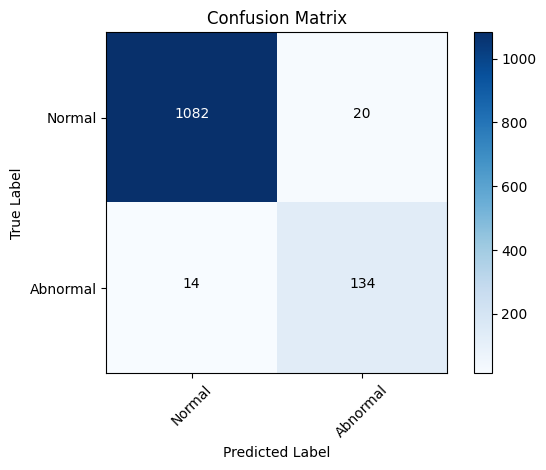

Accuracy : 0.9728
Precision : 0.9287
Recall : 0.9436
F1-score : 0.9360


In [13]:
""" 데이터 불균형한 상태에서 모델링 후, 모델 성능 파악 """

### 모델 Train & Test
dt_tree = tree.DecisionTreeClassifier(random_state=2025)
dt_tree.fit(X_train, y_train)
y_pred_test = dt_tree.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Normal', 'Abnormal']
cm_baseline = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_baseline, classes)
_, _, _, f1_baseline = calculate_classification_metrics(y_test, y_pred_test)

#### **1-3. GAN 모델 학습**

 - Dataset과 DataLoader 정의

 - 모델 구조 정의

 - GAN 모델 학습

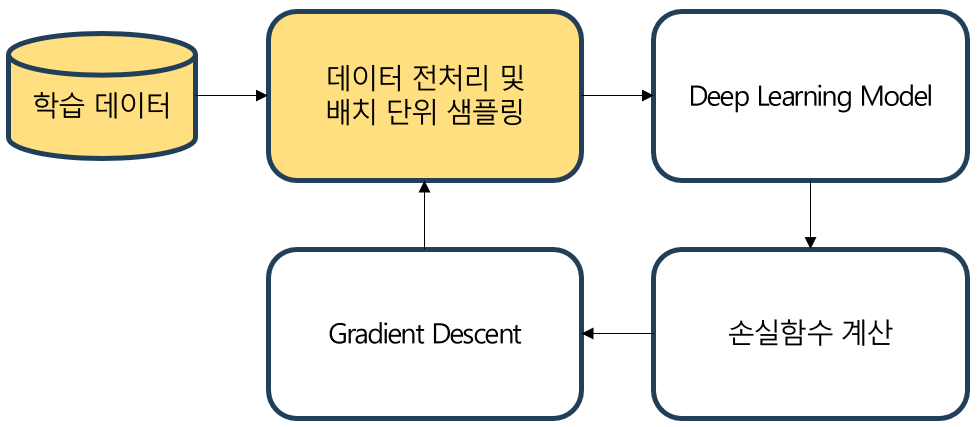

In [14]:
""" 설명 장표 불러오기 """
# Image('image/8-TrainingPhase1.PNG') ### 로컬 사용 시
Image('/content/2025-LGElec-Day22/image/8-TrainingPhase1.PNG') ### colab 사용 시

In [15]:
""" 1. pytorch 스타일 dataset 정의 """
class CustomDataset(Dataset):
    def __init__(self, X):
        super().__init__()

        self.X = X.to_numpy()

    def __getitem__(self, index):
        X = torch.FloatTensor(self.X[index])
        return X

    def __len__(self):
        return len(self.X)

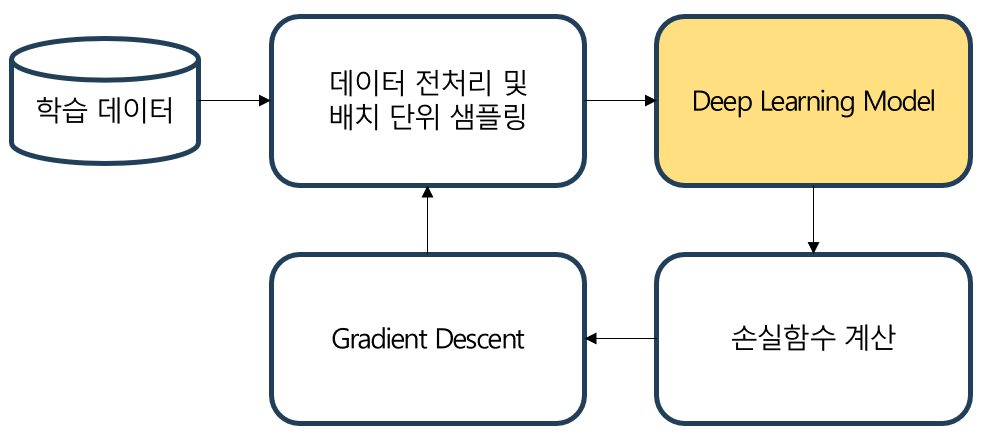

In [16]:
""" 설명 장표 불러오기 """
# Image('image/8-TrainingPhase2.PNG') ### 로컬 사용 시
Image('/content/2025-LGElec-Day22/image/8-TrainingPhase2.PNG') ### colab 사용 시

In [17]:
""" 2. pytorch 스타일 모델 구조 정의 """

### Generator 구조
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = F.leaky_relu(self.fc2(x), 0.1)
        x = F.leaky_relu(self.fc3(x), 0.1)
        return torch.tanh(x)


### Discriminator 구조
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)

        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)

        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(x)

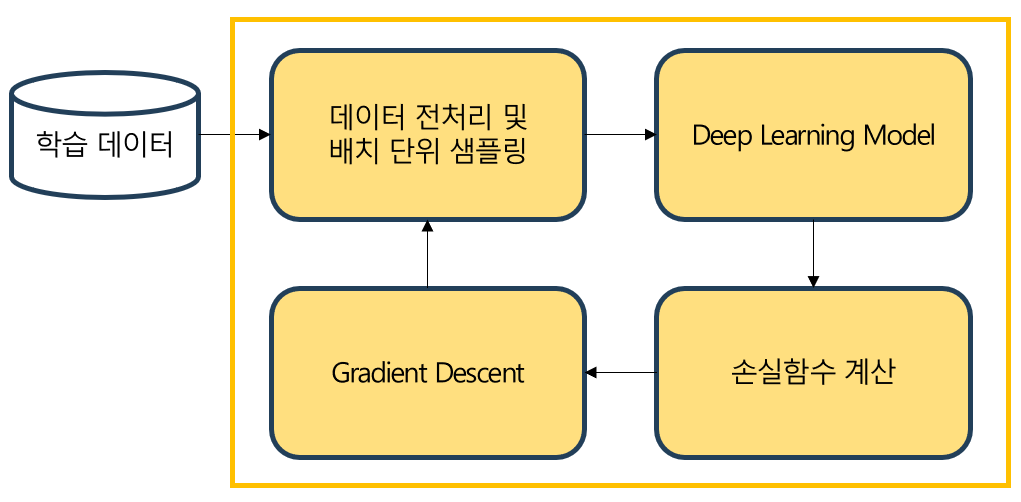

In [18]:
""" 설명 장표 불러오기 """
# Image('image/8-TrainingPhase3.PNG') ### 로컬 사용 시
Image('/content/2025-LGElec-Day22/image/8-TrainingPhase3.PNG') ### colab 사용 시

In [19]:
""" 3. GAN 모델 학습 """
### 소수 Class만 필터링 후, 학습 데이터셋 구축
X_minor = X_train[y_train['y'] == 1]
mino_datasets = CustomDataset(X_minor)
dataloader = DataLoader(mino_datasets,
                        batch_size=64,
                        sampler=torch.utils.data.RandomSampler(mino_datasets),
                        drop_last=True)

### 모델 하이퍼파라미터 정의
g_input_dim = 100
g_hidden_dim = 192
g_output_dim = 256
d_input_dim = 256
d_hidden_dim = 192
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 모델 정의
G = Generator(g_input_dim, g_hidden_dim, g_output_dim).to(device)
D = Discriminator(d_input_dim, d_hidden_dim).to(device)

### 목적함수 정의
criterion = nn.BCELoss()
criterion = criterion.to(device)

### Optimizer 정의
optimizer_g = optim.Adam(G.parameters(), lr=0.0002)
optimizer_d = optim.Adam(D.parameters(), lr=0.0002)

### 모델 학습
G.train()
D.train()
epochs = 100
g_losses, d_losses = [], []
for epoch in range(epochs):
    with tqdm(total=len(dataloader)) as tbar:
        for idx, X in enumerate(dataloader):

            ### 데이터 불러오기
            X = X.to(device=device)
            N, _ = X.size()

            ### 진짜와 가짜 Label 설정
            label_real = torch.ones(size=(N,1)).to(device=device)
            label_fake = torch.zeros(size=(N,1)).to(device=device)

            ### Discriminator 학습
            optimizer_d.zero_grad()
            output_real = D(X)
            d_loss_real = criterion(output_real, label_real) ### 실제 이미지에 대한 Loss

            z = torch.randn(N, g_input_dim).to(device=device)
            fake_imgs = G(z) ### 이미지 생성
            output_fake = D(fake_imgs)
            d_loss_fake = criterion(output_fake, label_fake) ### 생성된 가짜 이미지에 대한 Loss

            d_loss_total = d_loss_fake + d_loss_real
            d_loss_total.backward()
            optimizer_d.step()

            d_losses.append(d_loss_total.item())

            ### Generator 학습
            optimizer_g.zero_grad()
            z = torch.randn(N, g_input_dim).to(device=device)
            fake_imgs = G(z) ### 가짜 이미지 생성
            output_fake = D(fake_imgs) ### 생성된 이미지의 진짜 여부 판별

            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            optimizer_g.step()

            g_losses.append(g_loss.item())

            ### Log
            tbar.set_description('Epoch [{:3d}/{:3d}], d_loss: {:.4f}, g_loss: {:.4f}'.format(epoch+1, epochs, d_loss_total.item(), g_loss.item()))
            tbar.update(1)

Epoch [100/100], d_loss: 0.6632, g_loss: 1.4907: 100%|██████████| 5/5 [00:00<00:00, 88.94it/s]


<Axes: >

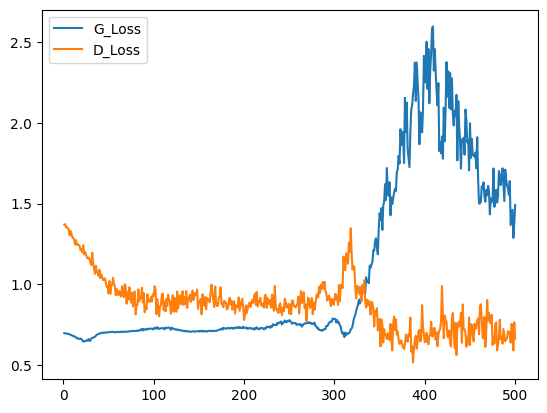

In [20]:
""" Generator와 Discriminator의 Loss 시각화"""
sns.lineplot(x=range(1, len(g_losses)+1), y=g_losses, label='G_Loss')
sns.lineplot(x=range(1, len(d_losses)+1), y=d_losses, label='D_Loss')

#### **1-4. 소수 Class Oversampling**

 - GAN 모델을 활용하여 데이터 생성

In [21]:
""" GAN 모델을 Inference하여 OverSampling """

### GAN 모델 Inference: Noise를 넣어 데이터 생성
n_sampling = 2000
G.eval()
with torch.no_grad():
    z = torch.randn(n_sampling, g_input_dim).to(device=device)
    X_gan = G(z)

### 실제 데이터와 유사한 형태로 정제
X_gan = X_gan.cpu().numpy()
y_gan = np.ones(shape=(len(X_gan),1))

X_gan.shape, y_gan.shape

((2000, 256), (2000, 1))

In [22]:
""" 기존 데이터와 합치기 """
X_resampled = np.concatenate([X_train, X_gan], axis=0)
y_resampled = np.concatenate([y_train, y_gan], axis=0)

print(f'X shape : {X_train.shape} ||| After Sampling : {X_resampled.shape}')

X shape : (3750, 256) ||| After Sampling : (5750, 256)


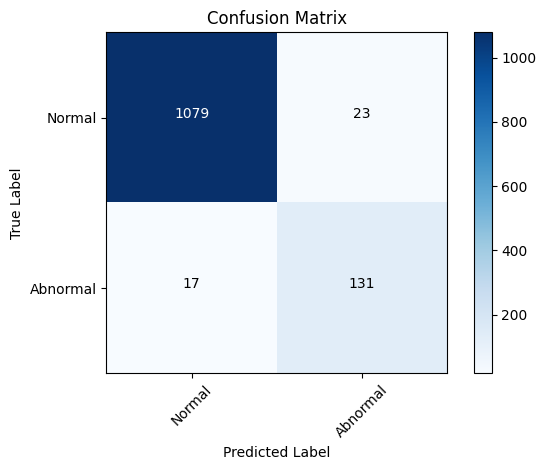

Accuracy : 0.9680
Precision : 0.9176
Recall : 0.9321
F1-score : 0.9247


In [23]:
""" GAN 기반 OverSampling 후, 모델 성능 파악 """

### 모델 Train & Test
dt_tree = tree.DecisionTreeClassifier(random_state=2025)
dt_tree.fit(X_resampled, y_resampled)
y_pred_test = dt_tree.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Normal', 'Abnormal']
cm_gan = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_gan, classes)
_, _, _, f1_gan = calculate_classification_metrics(y_test, y_pred_test)

#### **1-5. Baseline과 모델 성능 비교**

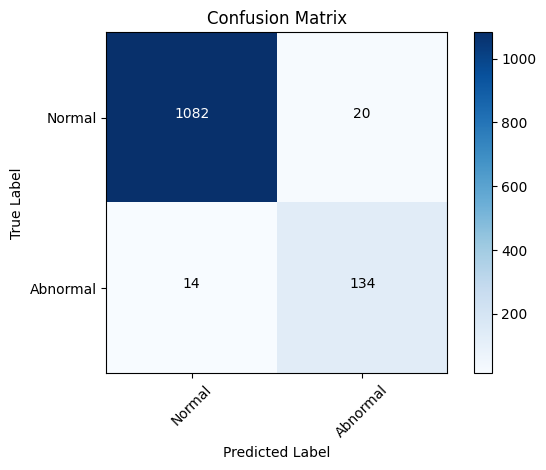

Accuracy : 0.9728
Precision : 0.9287
Recall : 0.9436
F1-score : 0.9360


In [24]:
""" Baseline 모델 성능 """

### 모델 Train & Test
dt_tree = tree.DecisionTreeClassifier(random_state=2025)
dt_tree.fit(X_train, y_train)
y_pred_test = dt_tree.predict(X_test)

### Confusion Matrix 시각화 및 성능 산출
classes = ['Normal', 'Abnormal']
cm_baseline = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm_baseline, classes)
_, _, _, f1_baseline = calculate_classification_metrics(y_test, y_pred_test)